In [19]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np


In [20]:
TRAIN = 'train'
VALID = 'valid'
TEST = 'test'

# MAKE SURE THE IMAGE FOLDER IS IN THE SAME DIR
def load_dataset(type):
    dList = ['/face', '/non-face']
    x_list = list()
    y_list = list()
    for d in dList:
        directory = type+d
        isFace = 1 if d=='/face' else -1
        for filename in os.scandir(directory):
            abs_path = os.path.abspath(filename.path)
            img = cv2.imread(abs_path)
            x_list.append(img)
            y_list.append(isFace)
    
    return {'data': np.array(x_list), 'target': np.array(y_list)}

In [77]:
class Rectangle:
    def __init__(self, x,y,w,h):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    
    def get_info(self):
        return self.x, self.y, self.w, self.h

class IntegralImage:
    def __init__(self, image):
        self.ii = self.compute_integral(image)
    
    
    def compute_integral(self, image, img_len=19):
        integralImage = np.zeros((img_len, img_len, 1))
        r_sum = np.zeros((img_len, img_len, 1))
        for h in range(img_len):
            for w in range(img_len):
                if (h>=1):
                    r_sum[h][w] = r_sum[h-1][w][0]+ image[h][w][0]
                else:
                    r_sum[h][w] = image[h][w][0]
                
                if(w>=1):
                    integralImage[h][w] = integralImage[h][w-1][0] + r_sum[h][w][0]
                else:
                    integralImage[h][w] = r_sum[h][w][0]
        return integralImage

    def get_intensity(self,rect: Rectangle):
        x,y,w,h = rect.get_info()
        return self.ii[y][x] - self.ii[y-h][x] - self.ii[y][x-w] + self.ii[y-h][x-w]


class FeatureRectangle(Rectangle):
    def __init__(self, x, y, w, h, feature_type):
        super().__init__(x,y,w,h)
        self.feature_type = feature_type
    
    def get_feature(self, integral_img: IntegralImage):
        # feature (A)
        if self.feature_type == (2,1):
            bbox = Rectangle(self.x, self.y, self.w // 2, self.h)
            wbox = Rectangle(self.x - (self.w // 2), self.y, self.w // 2, self.h)
            return integral_img.get_intensity(wbox) - integral_img.get_intensity(bbox)

        # feature (B) 
        if self.feature_type == (1,2):
            bbox = Rectangle(self.x, self.y - self.h //2, self.w, self.h //2)
            wbox = Rectangle(self.x, self.y, self.w, self.h //2)
            return integral_img.get_intensity(wbox) - integral_img.get_intensity(bbox) 

        # feature (C)
        if self.feature_type == (3,1):
            wbox1 = Rectangle(self.x - ((2*self.w) //3), self.y, self.w //3, self.h)
            wbox2 = Rectangle(self.x, self.y, self.w //3, self.h)
            bbox = Rectangle(self.x - (self.w// 3), self.y, self.w //3, self.h)
            return integral_img.get_intensity(wbox1) + integral_img.get_intensity(wbox2) - integral_img.get_intensity(bbox)
        
        # feture (D)
        if self.feature_type == (2,2):
            wbox1 = Rectangle(self.x, self.y - (self.h //2), self.w //2, self.h//2)
            wbox2 = Rectangle(self.x - (self.w //2), self.y, self.w //2, self.h//2)
            bbox1 = Rectangle(self.x - (self.w //2), self.y - (self.h //2), self.w //2, self.h//2)
            bbox2 = Rectangle(self.x, self.y, self.w //2, self.h//2)
            return integral_img.get_intensity(wbox1) + integral_img.get_intensity(wbox2) - integral_img.get_intensity(bbox1) - integral_img.get_intensity(bbox2)


In [22]:
from sklearn.model_selection import train_test_split

train_dataset = load_dataset(TRAIN)
test_dataset = load_dataset(TEST)
X_test = test_dataset['data']
y_test = test_dataset['target']

img_train, img_valid, y_train, y_valid = train_test_split(train_dataset['data'], train_dataset['target'], test_size=0.2)
ii_train = np.array([IntegralImage(img) for img in img_train])
ii_valid = np.array([IntegralImage(img) for img in img_valid])



In [129]:
from sklearn.ensemble import AdaBoostClassifier
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


class ViolaJones:
    def __init__(self, rounds=10, img_width=19, img_height=19):
        self.rounds = rounds
        self.feature_types = [(1,2), (2,1), (3,1), (2,2)]
        self.haar_features = self.make_Haar_features(max_width=img_width,max_height=img_height)
    
    def make_Haar_features(self, max_width, max_height):
        total_features = list()
        for ft in self.feature_types:
            type_features = list()
            for width in range(ft[0], max_width+1, ft[0]):
                for height in range(ft[1], max_height+1, ft[1]):
                    for x in range(width-1, max_width):
                        for y in range(height-1, max_height):
                            type_features.append(FeatureRectangle(x,y,width,height,ft))
            total_features += type_features
        return np.array(total_features)

    def convert_to_integral_images(self, img_list):
        ii_list = list()
        for img in img_list:
            ii_list.append(IntegralImage(img))
        return np.array(ii_list)
    
    def compute_haar(self, dataset):
        start = timer()
        X_data = np.empty((len(dataset), len(self.haar_features)))
        for i, int_img in enumerate(dataset):
            for j, hf in enumerate(self.haar_features):
                X_data[i][j] = hf.get_feature(int_img)
        haar_end = timer()
        print(f'Computation time for Haar feature: {haar_end - start}s')
        print(X_data.shape)
        return X_data
    
    def trainAdaBoost(self, train_x, train_y, valid_x, valid_y):
        start = timer()
        clf = AdaBoostClassifier(algorithm='SAMME', n_estimators=12)
        clf.fit(train_x, train_y)
        train_end = timer()
        print(f'Training time for AdaBoost: {train_end - start}s')
        print("Accuracy over validation: ", clf.score(valid_x, valid_y))
        
        f = clf.feature_importances_
        test_features = [self.haar_features[i] for i in range(len(f)) if f[i]!=0]
        return clf, test_features

    def testAdaBoost(self, test_X, test_y, features):
        test_size = len(test_X)
        f_start = timer()
        test_ii = self.convert_to_integral_images(test_X)
        f_end = timer()
        print(f'Time taken for feature compution: {f_end - f_start}s')
        img_start = timer()
        y_pred = np.empty((test_size ,))
        for i, img in enumerate(test_ii):
            res = 0
            for f in features:
                res += f.get_feature(img)
            y_pred[i] = 1 if res > 0 else -1
        i_end = timer()
        print(f'Time taken for each img: {(i_end - img_start) / test_size}s')
        cm = confusion_matrix(test_y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    

    def runRandomForest(self, train_x, train_y, valid_x, valid_y, test_X, test_y):
        test_size = len(test_X)

        rf_start = timer()
        clf = RandomForestClassifier(max_depth=5)
        clf.fit(train_x, train_y)
        rf_train = timer()
        print(f"Random Forest Training time: {rf_train - rf_start}s")
        print("Random Forest Accuracy over validation: ", clf.score(valid_x, valid_y))

        f = clf.feature_importances_
        test_features = [self.haar_features[i] for i in range(len(f)) if f[i]!=0]
        
        rf_test_start = timer()
        test_ii = self.convert_to_integral_images(test_X)
        y_pred = np.empty((test_size ,))
        for i, img in enumerate(test_ii):
            res = 0
            for f in test_features:
                res += f.get_feature(img)
            y_pred[i] = 1 if res > 0 else -1
        rf_test_end = timer()
        print(f"Random Forest Testing time: {rf_test_end - rf_test_start}s")
        

In [130]:
VJ = ViolaJones()

There are 53130 features in total


In [44]:
X_train = VJ.compute_haar(ii_train)
X_valid = VJ.compute_haar(ii_valid)

Computation time for Haar feature: 3007.6521535829997s
(5581, 53130)
Computation time for Haar feature: 748.8721532500003s
(1396, 53130)


In [52]:
classifier, features = VJ.trainAdaBoost(X_train, y_train, X_valid, y_valid)

Training time for AdaBoost: 273.9369497500011s
Accuracy over validation:  0.9520057306590258
Time taken for feature compution: 20.446450166997238s


ValueError: Expected 2D array, got 1D array instead:
array=[<__main__.IntegralImage object at 0x7fcae937b190>
 <__main__.IntegralImage object at 0x7fcb00845a60>
 <__main__.IntegralImage object at 0x7fcb00845a00> ...
 <__main__.IntegralImage object at 0x7fddcd4733a0>
 <__main__.IntegralImage object at 0x7fddcd473400>
 <__main__.IntegralImage object at 0x7fddcd473460>].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Time taken for feature compution: 19.951010083001165s
Time taken for each img: 0.00011714381023079328s


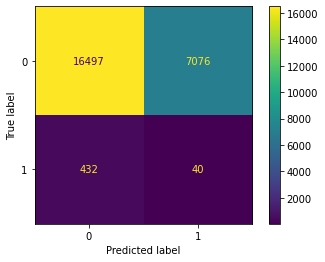

In [121]:
VJ.testAdaBoost(X_test, y_test, features)

Random Forest Training time: 29.875832041998365s
Random Forest Accuracy over validation:  0.9742120343839542
Random Forest Testing time: 663.6382501250009s


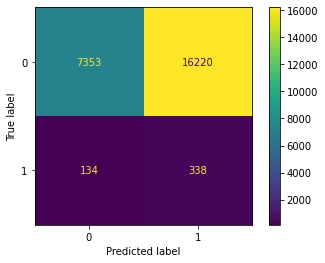

In [131]:
VJ.runRandomForest(X_train, y_train, X_valid, y_valid, X_test, y_test)

It is evident that due to the different nature of the algorithms, Adaboost is significantly slower during the training phase, but it can narrow down crucial features more quickly such that the performance is much better on-the-fly (testing). Random Forest on the other hand was much faster during the training phase and had a slightly higher accuracy, but it is much more slower for testing large number of files. This may have been attributed to the depth being too high, or the prorgram not optimized for parallel computation, which would benefit Random Forest a lot. 